In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/merged-dataset/test/pneumonia/image_180.png
/kaggle/input/merged-dataset/test/pneumonia/image_13.png
/kaggle/input/merged-dataset/test/pneumonia/image_135.png
/kaggle/input/merged-dataset/test/pneumonia/image_57.png
/kaggle/input/merged-dataset/test/pneumonia/image_58.png
/kaggle/input/merged-dataset/test/pneumonia/image_166.png
/kaggle/input/merged-dataset/test/pneumonia/image_101.png
/kaggle/input/merged-dataset/test/pneumonia/image_116.png
/kaggle/input/merged-dataset/test/pneumonia/image_175.png
/kaggle/input/merged-dataset/test/pneumonia/image_201.png
/kaggle/input/merged-dataset/test/pneumonia/image_81.png
/kaggle/input/merged-dataset/test/pneumonia/image_153.png
/kaggle/input/merged-dataset/test/pneumonia/image_199.png
/kaggle/input/merged-dataset/test/pneumonia/image_181.png
/kaggle/input/merged-dataset/test/pneumonia/image_184.png
/kaggle/input/merged-dataset/test/pneumonia/image_174.png
/kaggle/input/merged-dataset/test/pneumonia/image_227.png
/kaggle/input/merg

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

2025-04-17 20:20:46.110247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744921246.327980      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744921246.392023      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_path = '/kaggle/input/merged-dataset'

categories = ['covid19', 'normal', 'pneumonia']
images = []
labels = []

In [4]:
# Function to load images from a directory
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png') :  # Only process .jpg files
            img_path = os.path.join(folder, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

In [5]:
train_path = os.path.join(base_path, 'train')
for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category)
    
test_path = os.path.join(base_path, 'test')
test_images = []
test_labels = []
for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category)
    

Loading training data from /kaggle/input/merged-dataset/train/covid19...
Loading training data from /kaggle/input/merged-dataset/train/normal...
Loading training data from /kaggle/input/merged-dataset/train/pneumonia...
Loading test data from /kaggle/input/merged-dataset/test/covid19...
Loading test data from /kaggle/input/merged-dataset/test/normal...
Loading test data from /kaggle/input/merged-dataset/test/pneumonia...


In [6]:
images = np.array(images)
labels = np.array(labels)

# Dataset Summary

In [7]:
print("Number of images in total is ", len(images))
COVID19_count = 0
NORMAL_count = 0
PNEUMONIA_count = 0
for label in labels:
    if label == 'covid19':
        COVID19_count+=1
    elif label == 'normal':
        NORMAL_count +=1
    elif label == 'pneumonia':
        PNEUMONIA_count+=1
print(f"Number of images in COVID19 class is {COVID19_count}")
print(f"Number of images in NORMAL class is {NORMAL_count}")
print(f"Number of images in PNEUMONIA class is {PNEUMONIA_count}")

Number of images in total is  1244
Number of images in COVID19 class is 504
Number of images in NORMAL class is 498
Number of images in PNEUMONIA class is 242


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


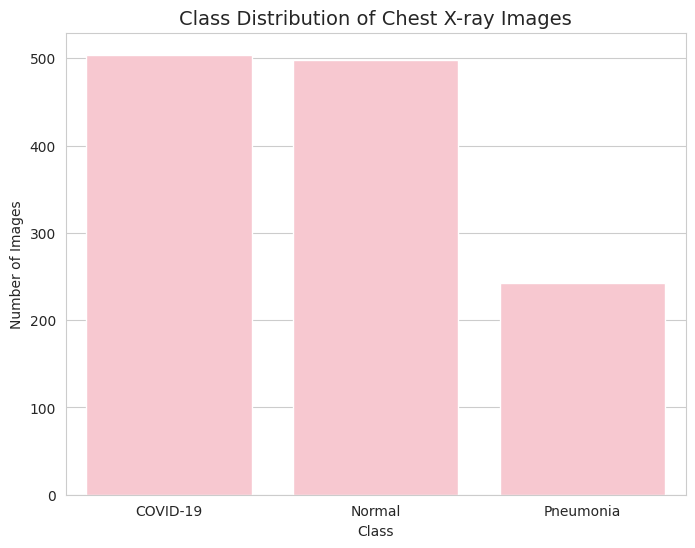

In [8]:
class_labels = ['COVID-19', 'Normal', 'Pneumonia']
counts = [COVID19_count, NORMAL_count, PNEUMONIA_count]

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=counts, color='pink')

plt.title('Class Distribution of Chest X-ray Images', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.show()

In [9]:
train_image_paths = []

for category in categories:
    category_path = os.path.join(train_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            full_path = os.path.join(category_path, filename)
            train_image_paths.append(full_path)

In [10]:
def check_image_modes(image_paths):
    mode_counts = {}
    for path in image_paths:
        try:
            with Image.open(path) as img:
                mode = img.mode  # 'L' for grayscale, 'RGB' for color
                mode_counts[mode] = mode_counts.get(mode, 0) + 1
        except Exception as e:
            print(f"Error opening {path}: {e}")
    return mode_counts

In [11]:

mode_summary = check_image_modes(train_image_paths)

# Print the result
print("Image mode summary:")
print(mode_summary)


Image mode summary:
{'RGB': 995}


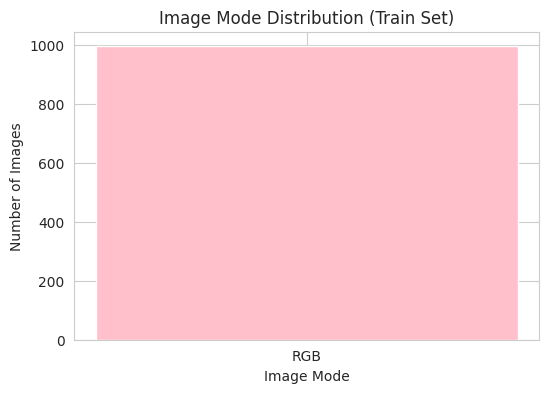

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(mode_summary.keys(), mode_summary.values(), color='pink')
plt.title("Image Mode Distribution (Train Set)")
plt.xlabel("Image Mode")
plt.ylabel("Number of Images")
plt.show()


# Histogram Intensity

In [13]:
image_Pneumonia = []
image_Normal = []
image_covid = []
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(len(images)):
    if labels[i] == 'pneumonia' and count_1 < 2 :
        image_Pneumonia.append(images[i])
        count_1 += 1
    elif labels[i] == 'normal' and count_2 < 2 :
        image_Normal.append(images[i])
        count_2 += 1
    elif labels[i] == 'covid19' and count_3 < 2:
        image_covid.append(images[i])
        count_3 += 1


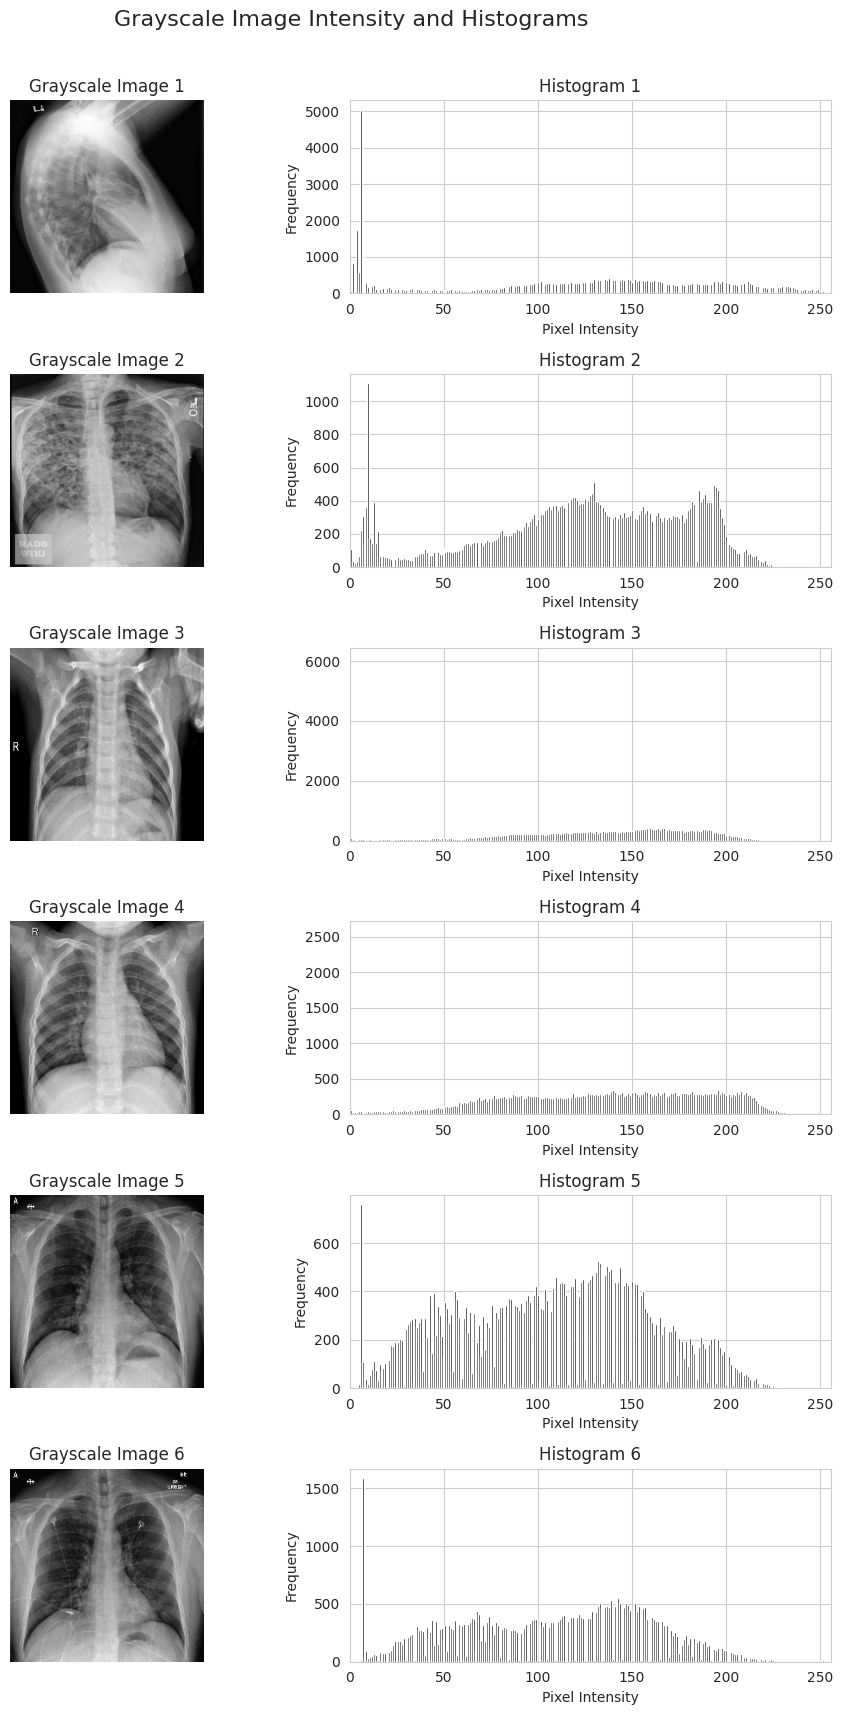

In [14]:
all_images = image_Pneumonia + image_Normal + image_covid

fig, axs = plt.subplots(6, 2, figsize=(10, 18))
fig.suptitle('Grayscale Image Intensity and Histograms', fontsize=16)

for i, img in enumerate(all_images):
    if img.dtype != np.uint8:
        img = np.clip(img * 255, 0, 255).astype(np.uint8)

    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    axs[i, 0].imshow(img_gray, cmap='gray')
    axs[i, 0].set_title(f'Grayscale Image {i+1}')
    axs[i, 0].axis('off')

    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    hist = hist.flatten()

    axs[i, 1].bar(range(256), hist, color='black', width=1)
    axs[i, 1].set_title(f'Histogram {i+1}')
    axs[i, 1].set_xlim([0, 256])
    axs[i, 1].set_xlabel('Pixel Intensity')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## Comment: Pneumonia class which is the first one is morse dark in intenisty with high frequency, Normal with is the 3rd and 4th are centered and low frequency, the last ones which are covid are distributed with normal frequencies

# Visualizing a Sample of Each Class

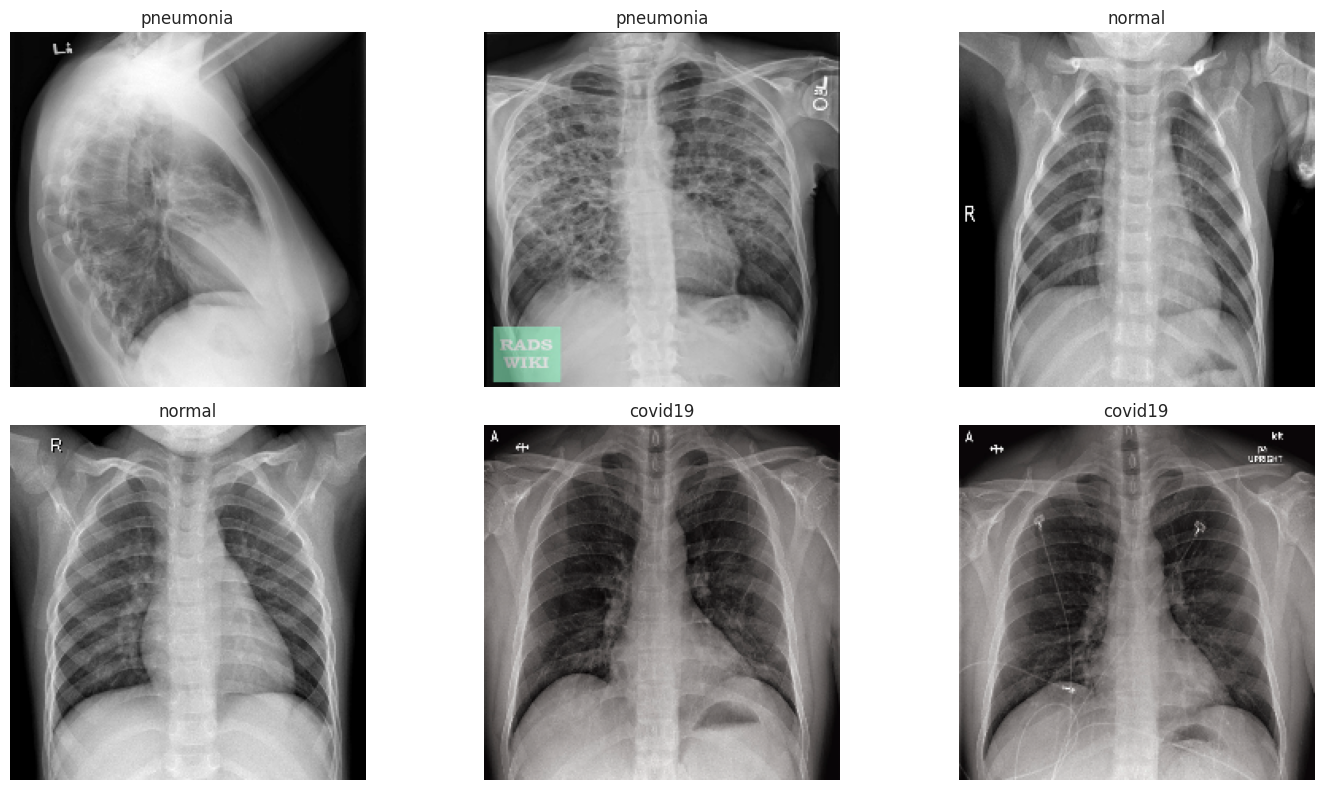

In [15]:
classes = ['pneumonia', 'pneumonia', 'normal', 'normal', 'covid19', 'covid19']

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(all_images[idx])
        axs[i, j].set_title(classes[idx])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


# Checking for Very Dark/Bright Images

In [16]:
Dark_images = []
Light_images = []

for i, img in enumerate(images):
  if img.dtype != np.uint8:
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
  img_array = np.array(img)
  mean_intensity = img_array.mean()

  if(mean_intensity < 60):
      print("images with index", i, "is too dark")
      Dark_images.append(img)

  if(mean_intensity > 200):
      print("images with index", i, "is too light")
      Light_images.append(img)
print(f"There are {len(Dark_images)} images that are too dark, and {len(Light_images)} images that are too light.")

images with index 210 is too dark
images with index 374 is too light
There are 1 images that are too dark, and 1 images that are too light.


## Comment: Out of over 1,244 images, only 2 are considered low-quality, based on the assumption that their mean pixel intensity is below 60 or above 200

# Visualize intensity of Sample Images by Boxplots

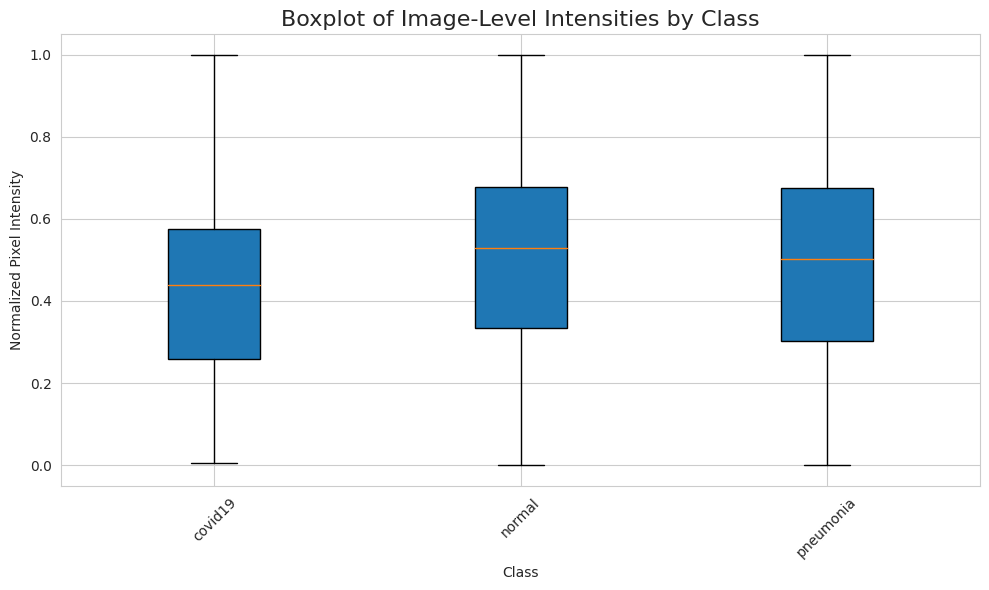

In [17]:
all_images = image_Pneumonia + image_Normal + image_covid

classes = ['pneumonia'] * len(image_Pneumonia) + ['normal'] * len(image_Normal) + ['covid19'] * len(image_covid)

intensities_by_class = {cls: [] for cls in set(classes)}

for img, cls in zip(all_images, classes):

    if img.dtype != np.uint8:
        img = np.clip(img * 255, 0, 255).astype(np.uint8)

    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    intensities = img_gray.flatten() / 255.0
    intensities_by_class[cls].extend(intensities)

data_to_plot = [intensities_by_class[cls] for cls in sorted(intensities_by_class.keys())]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, vert=True, patch_artist=True)
plt.title('Boxplot of Image-Level Intensities by Class', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Normalized Pixel Intensity')
plt.xticks(range(1, len(data_to_plot) + 1), sorted(intensities_by_class.keys()), rotation=45)
plt.tight_layout()
plt.show()

# PCA to identify the separability of classes

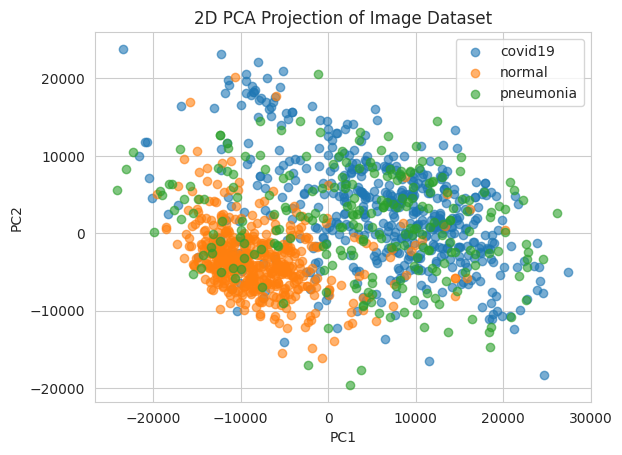

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = images.reshape(images.shape[0], -1)
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

unique_labels = sorted(set(labels))

clusters = []
for label in unique_labels:
  cluster =[]
  for i, l in enumerate(labels):
    if l == label:
      cluster.append(i)
  clusters.append(cluster)

for i, cluster in enumerate(clusters):
    plt.scatter(X_2d[cluster, 0], X_2d[cluster, 1], label=unique_labels[i], alpha=0.6)

plt.title("2D PCA Projection of Image Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()